# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn
main_path = '/mnt/raid/ni/agnessa/RSA/'


# Define the function to create filenames

In [2]:
def getFileName(n_samples,name,model_name,layer_name):
    return name \
        + "_{}_".format(n_samples) \
        + "_{}_".format(model_name) \
        + "_{}".format(layer_name)  \
        + ".npy"       

# Average correlation of a subset of layers for two networks (same model, different training tasks) - use the whole matrix (not just upper triangular)

In [8]:
def avg_correlation_cross_task(model_name,trained_on,tested_on,min_layer_idx,max_layer_idx):
    layer_name = 'all'
    
    #define number of samples depending on the testing dataset
    if tested_on == 'ImageNet':
        n_samples = 10000
    elif tested_on == 'Places365':
        n_samples = 10220
        
    #load the models
    if tested_on == 'ImageNet':
        within_images_filename = os.path.join(main_path,'Objects','','Model_RDM', \
                                          getFileName(n_samples,'Model_RDM',model_name,layer_name))
    else:
        within_images_filename = os.path.join(main_path,'Objects',tested_on,'Model_RDM', \
                                          getFileName(n_samples,'Model_RDM',model_name,layer_name))
    
    within_scenes_filename = os.path.join(main_path,'Scenes',tested_on,'Model_RDM', \
                                      getFileName(n_samples,'Model_RDM',model_name,layer_name))
    model_name_across = model_name+'_'+model_name
    across_tasks_filename = os.path.join(main_path,trained_on,tested_on,'Model_RDM', \
                                      getFileName(n_samples,'Model_RDM_cross_task',model_name_across,layer_name))  
    
    #not all cross-task model RDMs are saved under the same path
    try:
        with open(across_tasks_filename): pass
    except IOError:
        across_tasks_filename = os.path.join(main_path,'Objects','','Model_RDM', \
                              getFileName(n_samples,'Model_RDM_cross_task',model_name_across,layer_name))  
        try:
            with open(across_tasks_filename): pass
        except IOError:
            print('check manually')
                
    #load and select only the desired layers
    model_rdm_within_images = np.load(within_images_filename)
    model_rdm_within_scenes = np.load(within_scenes_filename)
    model_rdm_across_tasks = np.load(across_tasks_filename)
    selected_model_rdm_within_images = model_rdm_within_images[min_layer_idx:max_layer_idx+1,min_layer_idx:max_layer_idx+1]#plus one makes sure that the last layer is included
    selected_model_rdm_within_scenes = model_rdm_within_scenes[min_layer_idx:max_layer_idx+1,min_layer_idx:max_layer_idx+1]
    selected_model_rdm_across_tasks = model_rdm_across_tasks[min_layer_idx:max_layer_idx+1,min_layer_idx:max_layer_idx+1]
   
    #get the correlation
    avg_corr_1 = 1-np.mean(selected_model_rdm_within_images)
    avg_corr_2 = 1-np.mean(selected_model_rdm_within_scenes)
    avg_corr_3 = 1-np.mean(selected_model_rdm_across_tasks)
    
    return avg_corr_1, avg_corr_2, avg_corr_3

# Plot the correlations (bar plot)

In [90]:
def bar_plot_correlations(**kwargs):
    
    ## Model name labels ## 

    #model name labels
    def autolabel(bars, model_name_label, height): 
        """Attach a text label above each quadruplet of bars (in the middle), displaying the model name."""
        for b in bars:
            if bars.index(b)==0:
                ax.annotate('{}'.format(model_name_label),
                            xy=(b.get_x() + b.get_width()*2.5, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',
                            fontsize=25,
                            color='mediumblue')
                xy=(b.get_x() + b.get_width()*2.5, height)
                
    #get the max correlation for the y coord of model name labels
    num_bars = 3 #1 for within-images, 1 for within-scenes, 1 for across-tasks
    all_correlations = np.ones((len(kwargs),num_bars*2))
    all_correlations[:] = np.nan
    for index,k in enumerate(kwargs):
        correlations = (kwargs.get(k)).get('correlations')
        all_correlations[index,:] = correlations.flatten()      
    max_height = np.max(all_correlations)              
        
    ## Bar plot ## 
    
    #setup the figure
    fig, ax = plt.subplots(figsize=(23,17))
    width = 0.25   
    num_layer_groups = 2
    x_all = np.ones((len(kwargs),num_layer_groups))
    x_all[:] = np.nan    
    
    #loop over models to make the bar plots
    for index,k in enumerate(kwargs):
        correlations = (kwargs.get(k)).get('correlations')
        x = np.arange(num_layer_groups)+2.5*index
        print(correlations[0,:])
        within_img = plt.bar(x, correlations[0,:], width, label='Within images', color='purple')
        within_sc = plt.bar(x+width, correlations[1,:], width, label='Within scenes', color='maroon')
        across_tasks = plt.bar(x + width*2, correlations[2,:], width, label='Across tasks', color='lightseagreen')
        x_all[index,:] = x
        autolabel(within_img,(kwargs.get(k)).get('model name'),max_height)
    print(x_all.shape)
    #plotting parameters
    font_small = 25
    font_title = 30
    plt.title('Average correlations for early and late layers in the within-task and across-task RDMs',fontsize=font_title)
    plt.xticks(x_all.flatten() + width, (['Early layers', 'Late layers'] * len(kwargs)),
               fontsize=font_small)
    plt.yticks(fontsize=font_small)
    plt.ylabel('Spearman\'s coefficient',fontsize=font_small)
    plt.legend([within_img,within_sc,across_tasks],['Within images', 'Within scenes','Across tasks'],
               loc=1, bbox_to_anchor=(0.45,0.95), fontsize=font_small) #can do it for just one of the models
    
    plt.show()
    return fig

[0.83023589 0.7438253 ]
[0.61445729 0.80243776]
[0.6999556  0.78208295]
(3, 2)


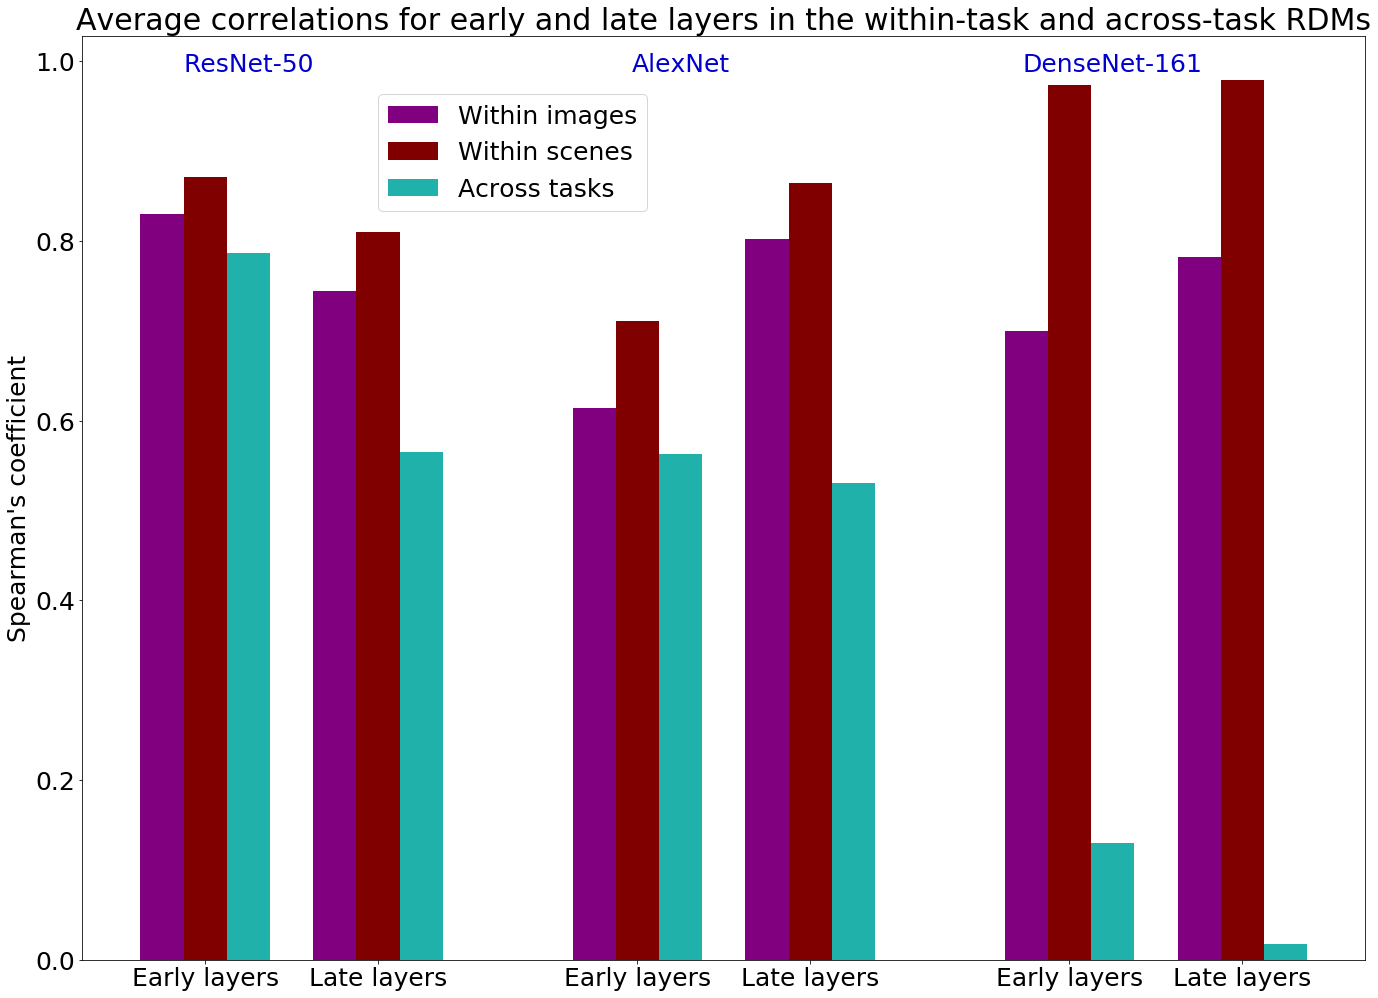

In [91]:
#choose the datasets and models
trained_on_cross_task = 'Scenes'
tested_on = 'ImageNet'

model_name_1 = 'resnet50'
model_name_2 = 'alexnet'
model_name_3 = 'densenet161'

#get the correlations
mod1_within_img_early,mod1_within_sc_early,mod1_across_early = avg_correlation_cross_task(model_name_1,trained_on_cross_task,tested_on,0,6)
mod1_within_img_late,mod1_within_sc_late, mod1_across_late = avg_correlation_cross_task(model_name_1,trained_on_cross_task,tested_on,7,15)
mod2_within_img_early,mod2_within_sc_early,mod2_across_early = avg_correlation_cross_task(model_name_2,trained_on_cross_task,tested_on,0,8)
mod2_within_img_late,mod2_within_sc_late,mod2_across_late = avg_correlation_cross_task(model_name_2,trained_on_cross_task,tested_on,9,20)
mod3_within_img_early,mod3_within_sc_early,mod3_across_early = avg_correlation_cross_task(model_name_3,trained_on_cross_task,tested_on,0,7)
mod3_within_img_late,mod3_within_sc_late, mod3_across_late = avg_correlation_cross_task(model_name_3,trained_on_cross_task,tested_on,8,15)

#plot the correlations
fig = bar_plot_correlations(corr_model_1={'model name': 'ResNet-50', 'correlations': np.array([[mod1_within_img_early,mod1_within_img_late],
                                                                                               [mod1_within_sc_early,mod1_within_sc_late],
                                                                                               [mod1_across_early,mod1_across_late]])}, 
                            corr_model_2={'model name': 'AlexNet', 'correlations': np.array([[mod2_within_img_early,mod2_within_img_late],
                                                                                             [mod2_within_sc_early,mod2_within_sc_late], 
                                                                                             [mod2_across_early,mod2_across_late]])},
                            corr_model_3={'model name': 'DenseNet-161', 'correlations': np.array([[mod3_within_img_early,mod3_within_img_late],
                                                                                                  [mod3_within_sc_early,mod3_within_sc_late], 
                                                                                                  [mod3_across_early,mod3_across_late]])})

#save the bar plot
num_models = 3

if num_models == 2:
    path_png = os.path.join(main_path + 'other_plots', "{}_{}_{}_{}_{}.png".format(
        'avg_corr_bar_plot',trained_on_cross_task,tested_on,model_name_1,model_name_2))
    path_svg = os.path.join(main_path + 'other_plots', "{}_{}_{}_{}_{}_{}.svg".format(
        'avg_corr_bar_plot',trained_on_cross_task,tested_on,model_name_1,model_name_2))
elif num_models == 3:
    path_png = os.path.join(main_path + 'other_plots', "{}_{}_{}_{}_{}_{}_{}.png".format(
        'avg_corr_bar_plot',trained_on_cross_task,tested_on,model_name_1,model_name_2,model_name_3))
    path_svg = os.path.join(main_path + 'other_plots', "{}_{}_{}_{}_{}_{}_{}.svg".format(
        'avg_corr_bar_plot',trained_on_cross_task,tested_on,model_name_1,model_name_2,model_name_3))
fig.savefig(path_png)
fig.savefig(path_svg)
